# Pricing AirBnB

## Exploring the Data Set

As with every data set, you first want to know what you are dealing with. You perform some exploratory data analysis and clean the data along the way.

Show a few data points contained in the data set. Include all attributes.



In [2]:
#The following libraries will be needed for further investigation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import networkx
import sklearn

from p_decision_tree.DecisionTree import DecisionTree
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.neural_network import MLPRegressor

In [3]:
df = pd.read_csv('./AirBnB_original.csv') 
df.head()

,id,host id,neighborhood group,neighborhood,lat,long,country,country code,instant bookable,cancellation policy,room type,construction year,price,service fee,minimum nights,number of reviews,review rate number,calculated host listings count,number rooms
0,1001254,80014485718,Brooklyn,Kensington,40.64749,-73.97237,United States,US,0,strict,Private room,2020.0,966,193.0,7.0,9.0,4.0,6.0,1
1,1002102,52335172823,Manhattan,Midtown,40.75362,-73.98377,United States,US,0,moderate,Entire home/apt,2007.0,142,28.0,7.0,45.0,4.0,2.0,2
2,1002403,78829239556,Manhattan,Harlem,40.80902,-73.94190,United States,US,0,flexible,Private room,2005.0,620,124.0,3.0,0.0,5.0,1.0,1
3,1002755,85098326012,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,0,moderate,Entire home/apt,2005.0,368,74.0,7.0,270.0,4.0,1.0,2
4,1003689,92037596077,Manhattan,East Harlem,40.79851,-73.94399,United States,US,0,moderate,Entire home/apt,2009.0,204,41.0,7.0,9.0,3.0,1.0,1


## Basic Cleaning

First, you have to remove NaN entries across the data set such that we only keep rows without any NaN value. How many rows did you remove?

In [4]:
df2 = df.dropna().reset_index(drop=True)
print(f"{df.shape[0] - df2.shape[0]} rows have been removed.")

1477 rows have been removed.


Since duplicated entries are misleading, we want to remove duplicate flats (identified by their id), such that we only keep them once and create a new dataset. How many duplicates are removed?

In [5]:
df3 = df2.drop_duplicates('id').reset_index(drop=True)
print(f"{df2.shape[0] - df3.shape[0]} rows have been removed.")

389 rows have been removed.


From now on, you work with the dataset **AirBnB_cleaned.csv**.

To get a feeling for nightly prices in New York, you take a look at the price attribute. Calculate the average price, the first and third quantiles, and the standard deviation.

In [6]:
df = pd.read_csv('./AirBnB_cleaned.csv') 
mean = df["price"].mean()
std = df["price"].std()
p025 = df["price"].quantile(q=0.25)
p075 = df["price"].quantile(q=0.75) 
print(f"Mean: {mean:.2f}, std: {std:.2f}, 1st quartile: {p025:.0f}, 3rd quartile: {p075:.0f}")

Mean: 625.46, std: 331.24, 1st quartile: 340, 3rd quartile: 913


You want to get a more visual picture of the price range. Use a histogram and boxplot to show the distribution of prices on the entire dataset.

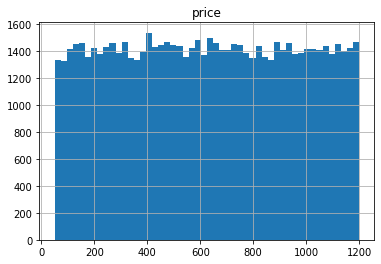

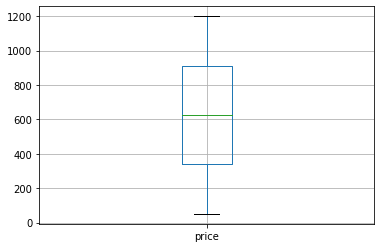

In [7]:
df.hist(column="price", bins=50)
plt.figure()
df.boxplot(column="price");

## Exploring Price Relationships 

To inform our pricing decision, we want to investigate some differentiating factors for pricing apartments.

Since you have an overview of the prices and their distribution, you want to investigate which features of your dataset you might use to make your pricing decision. To do so, discuss each feature of the dataset and already rule out features that will definitely not impact the pricing decision. Below you can find a brief description of each feature: 

- id: Unique identifier for an apartment
- host id: Identifier of the host offering a certain apartment
- neighborhood group: Name of a neighborhood group in which an apartment is located
- neighborhood: More fine-grained view on neighborhoods than neighborhood group
- lat: Latitude coordinate of an apartment
- long: Longitude coordinate of an apartment
- country: The country in which an apartment is located
- country code: Code of the country in which an apartment is located
- instant bookable: Boolean values if an apartment is instantly bookable
- cancellation policy: Policy for cancellation of booking
- room type: Type of apartment/room
- construction year: Year of construction of apartment
- price: Price for renting an apartment
- service fee: Fee of service
- minimum nights: Number of minimum nights to rent an apartment
- number of reviews: Number of reviews for an apartment
- review rate number:  Review rate for an apartment (1 to 5)
- calculated host listings count: Number of listings a host has
- number rooms: Number of rooms in an apartment

In [8]:
# For the numerical features we can get a first impression by
# printing the Pearson correlation coefficients with price.
cor = df.corr(numeric_only=True)['price']
print(cor.sort_values(ascending=False))

price                             1.000000
service fee                       0.999991
number rooms                      0.317470
number of reviews                 0.008259
id                                0.007083
host id                           0.006699
long                              0.002518
construction year                -0.000497
calculated host listings count   -0.000796
minimum nights                   -0.001062
lat                              -0.003476
review rate number               -0.010797
instant bookable                       NaN
Name: price, dtype: float64


_Answer:_ 

- **id**: Since every apartment has a unique identifier, which can be chosen arbitrarily, it does not tell anything about the characteristics of the apartment and is therefore not important for the pricing
- **host id**: Similar as for the apartment id
- **neighborhood group**: It is known that certain districts (i.e. neighborhood groups) are more expensive than others, for example the Manhatten is much more expensive than for example Brooklyn.
- **neighborhood**: It is known that certain neighborhoods are more expensive than others, for example inner city, suburban and rural areas vary largely in price.
- **lat**: It seems very unlikely that lattitute is correlated with price. For example if there are high price buildings in the north of a district it's not unlikely that there are cheaper buildings further south.
- **long**: Similar argument as for *lat*. Very unlikely that this variable is related to price.
- **country**: Usually important for pricing because of the different life standards in different countries but since the dataset only containt apartments in the US, it does not need to be considered.
- **country code**: Same argument as for *country*. Not important here.
- **instant bookable**: If an apartment is currently vacant or not gives no information about the price.
- **cancellation policy**: There is no clear logical connection between cancellation policy and price that we can think of. We assume there is no correlation.
- **room type**: Type should be considered for pricing because a whole apartment is usually more expensive than a single room.
- **construction year**: New building have more value so it should be considered in the pricing.
- **service fee**: Should be considered in the pricing due to the cost for utilities and cleaning of a stay, i.e. more expensive apartments have probably more expensive appliances.
- **minimum nights**: Not directly connected to the price of the apartment, but normally there is a discount for a longer stay
- **number of reviews**: Probably not important, if more people book cheaper housing then there would be more reviews for cheaper housing. But we don't know this apriori.
- **review rate number**: Same as no. of reviews. No clear direct connection can be identified.
- **calculated host listings count**: It is not clear that renters with more listings offer overall cheaper prices. One could also imagine someone with lots of luxury objects to rent. So we see no direct connection.
- **number rooms**: Should be considered in the pricing because apartments with more rooms are normally more expensive.

#### Features that do not impact pricing
- id
- host id
- lat
- long
- country
- country id
- instant bookable
- cancellation policy
- minimum nights
- number of review
- review rate number
- calculated host listings count

#### Features that do impact pricing
- neighborhood group
- neighborhood
- room type
- construction year
- service fee
- number rooms

## Univariate Analysis

In the following, you want to analyze which features influence the price. You do this univariately, i.e., look at the relationship between one feature and the price individually. No matter which features you concluded to be useful in the last task, **you will consider the following seven features: service fee, minimum nights, neighborhood group, room type, cancellation policy, construction year, and the number of rooms.**

First, we look closely at the relationship between price and service fee. To do so, create a joint plot for these two attributes. What is your finding? Is this a helpful feature for our pricing decision?

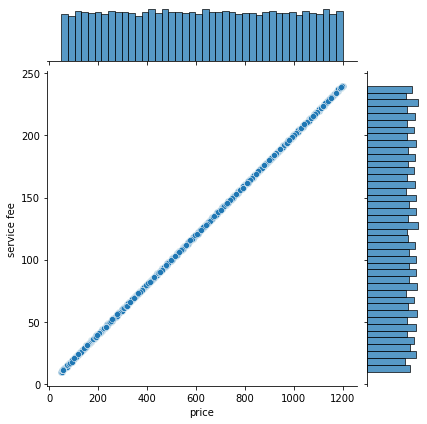

In [9]:
sns.jointplot(data=df[['price','service fee']], x="price", y="service fee")

_Answer:_ As observed before, the plot makes it visually very clear that service fee is almost perfectly (positively) correlated with the price.

Next, we are interested in the relationship between the number of minimum nights and the price. To analyze it, create a joint plot with a regression. Describe your observation.

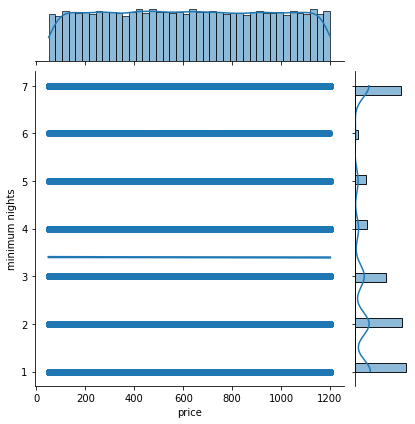

In [10]:
sns.jointplot(data=df[['price','minimum nights']], x="price", y="minimum nights", kind='reg')

Answer: Even without the regression we can conclude that there is no noticable correlation between price and number of minimum nights. This confirms our observation from above. The prices are uniformly distributed amongst number of minimum nights. We have most data for 1,2 and 7 nights.

To further investigate the pricing decision, you look at the remaining five features: neighborhood group, room type, cancellation policy, construction year, and the number of rooms. To get an overview, you decide to create box plots (including the mean) for each of these features to visualize their influence on the price. Describe your findings. Which values of the features influence the price? 

<AxesSubplot: xlabel='number rooms', ylabel='price'>

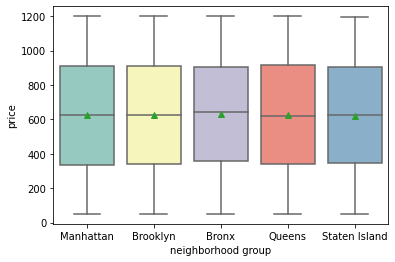

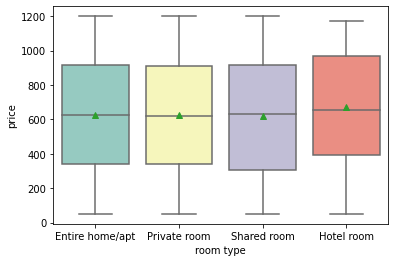

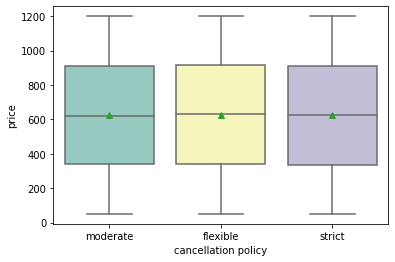

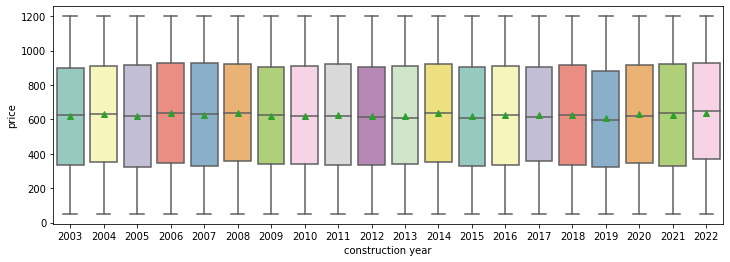

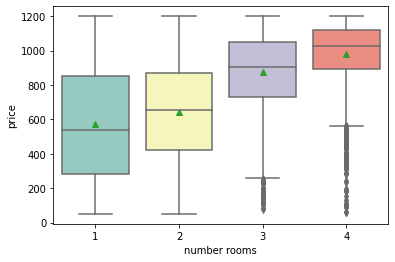

In [11]:
sns.boxplot(data=df, x="neighborhood group", y="price", palette="Set3", showmeans=True)
plt.figure()
sns.boxplot(data=df, x="room type", y="price", palette="Set3", showmeans=True)
plt.figure()
sns.boxplot(data=df, x="cancellation policy", y="price", palette="Set3", showmeans=True)
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="construction year", y="price", palette="Set3", showmeans=True)
plt.figure()
sns.boxplot(data=df, x="number rooms", y="price", palette="Set3", showmeans=True)

Answer: We can see that only number of rooms is correlated to price. The closeness of the mean to the median and the central position within the 1st and 3rd quantile let's us safely conclude that in all cases the data within the bins is pretty much Gaussian distributed.

## Multivariate Analysis

As the univariate analysis of price relationships provided only limited insights, you decide to visualize some multivariate investigations of the price. **No matter what you concluded in the last section, you will use the features construction year, number of rooms, room type, and neighborhood group in the multivariate analysis.**
For each pair of features, create a grouped boxplot (using the hue argument) and investigate whether the two features together allow for an explanation of price differences. In the end, conclude which combination of features should be used to make your pricing decision. 

#### Multivariate Analysis for Neighborhood Group

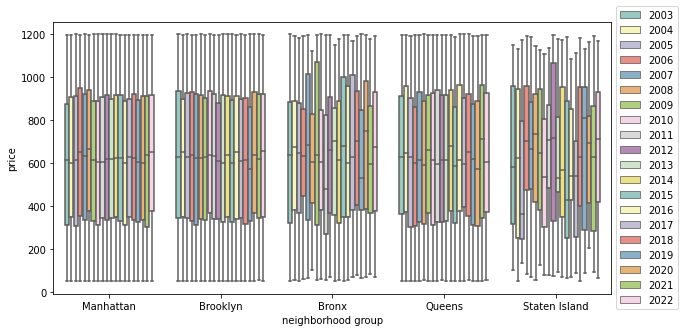

<Figure size 432x288 with 0 Axes>

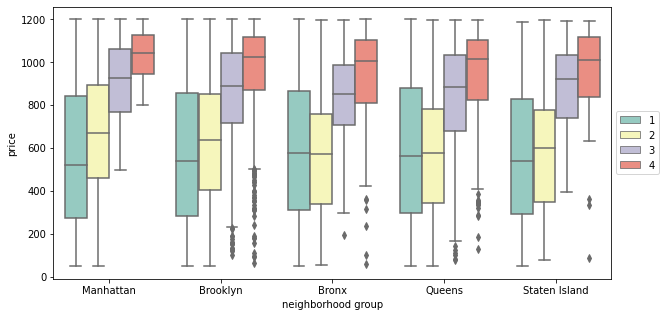

<Figure size 432x288 with 0 Axes>

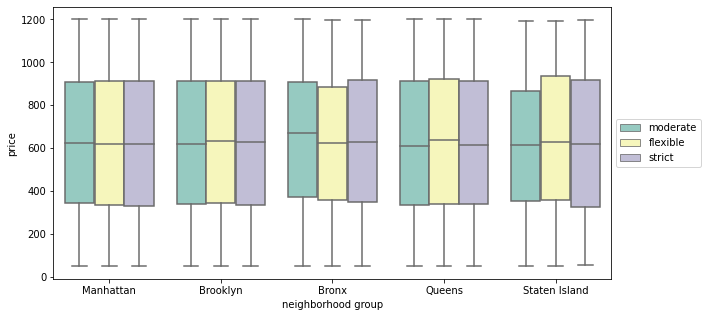

<Figure size 432x288 with 0 Axes>

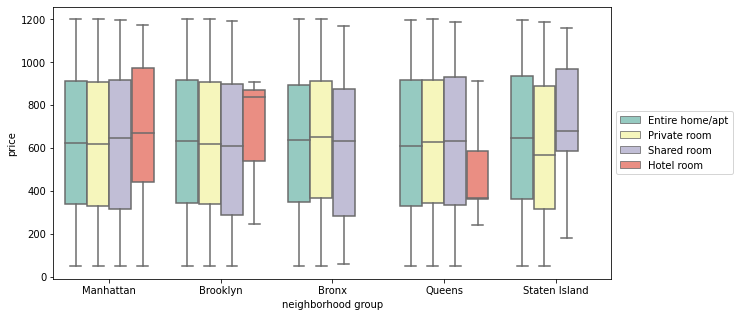

<Figure size 432x288 with 0 Axes>

In [12]:
for hue in ["construction year", "number rooms", "cancellation policy", "room type"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="neighborhood group", y="price", palette="Set3", hue=hue)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()

_Answer:_ The prices in each neighborhood group are pretty much comparable. No noteworthy multi-variate correlation including neighborhood groups with the price is noticable.

#### Multivariate Analysis for Room Type

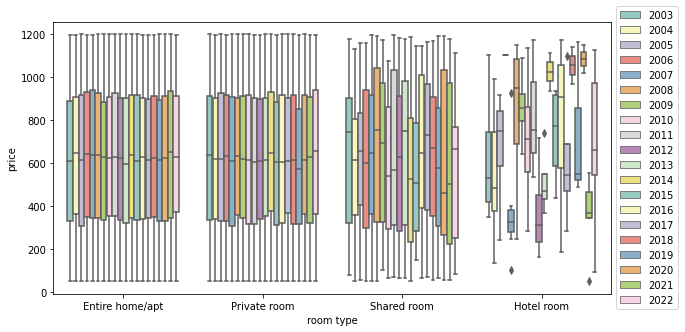

<Figure size 432x288 with 0 Axes>

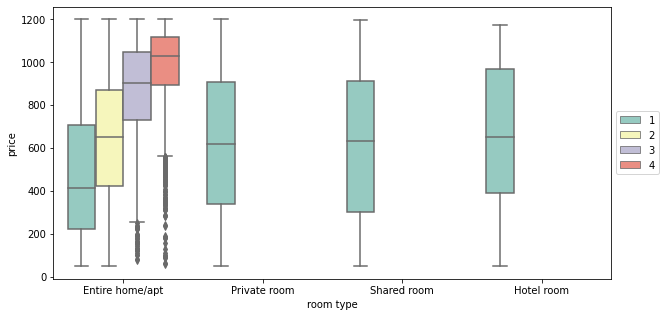

<Figure size 432x288 with 0 Axes>

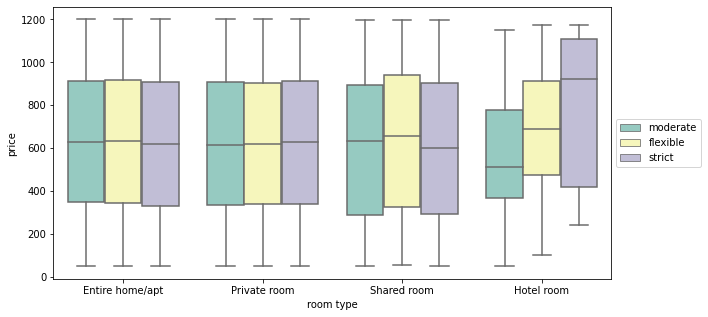

<Figure size 432x288 with 0 Axes>

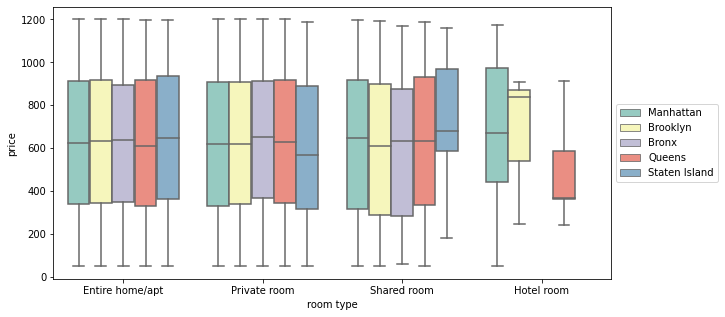

<Figure size 432x288 with 0 Axes>

In [13]:
for hue in ["construction year", "number rooms", "cancellation policy", "neighborhood group"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="room type", y="price", palette="Set3", hue=hue)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()

_Answer:_ Most striking is that only entire homes offer more than one room (which makes intuitive sense as the other categories are all labeled *rooms*). Thus, the entire correlation of number of rooms with price is carried by the category *entire home/apt*. Concerning the other room type categories, the price distribution looks more or less the same, making "room_type==entire home/apt" probably a good binary decision to split on (in a decision tree). Thus, the two variables (room type, number rooms) look like a promising candidate for predicting the price.

#### Multivariate Analysis for Number of Rooms

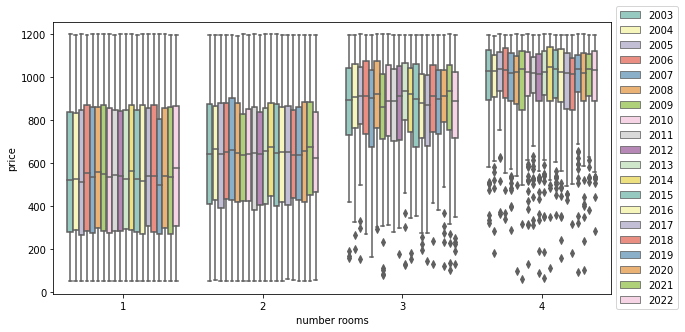

<Figure size 432x288 with 0 Axes>

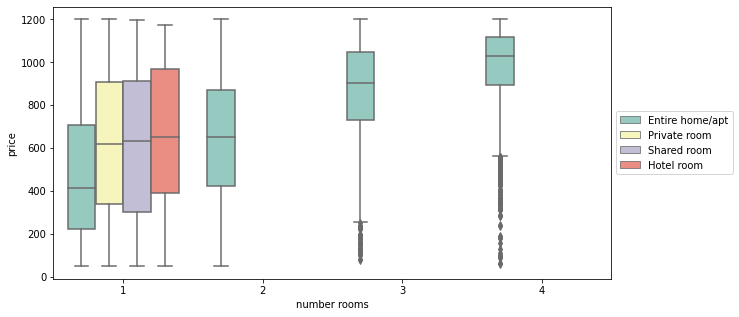

<Figure size 432x288 with 0 Axes>

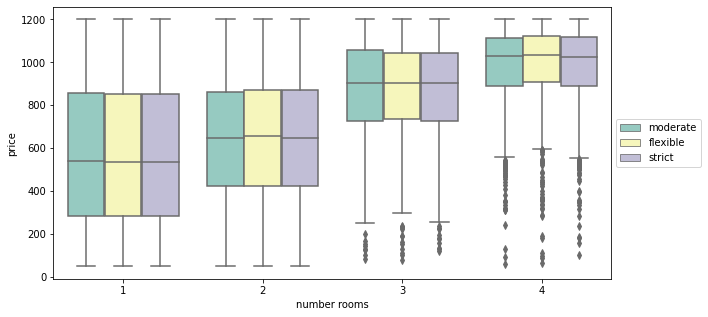

<Figure size 432x288 with 0 Axes>

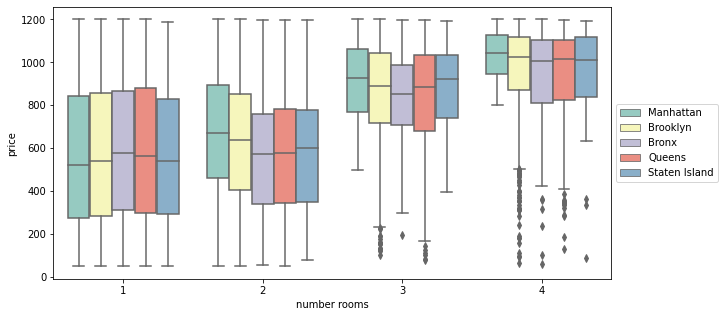

<Figure size 432x288 with 0 Axes>

In [14]:
for hue in ["construction year", "room type", "cancellation policy", "neighborhood group"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="number rooms", y="price", palette="Set3", hue=hue)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()

_Answer:_ As noted above, the combination (room type, number rooms) is most striking. The other combinations of variables with number of rooms show no notable correlation to price.

#### Multivariate Analysis for Construction Year

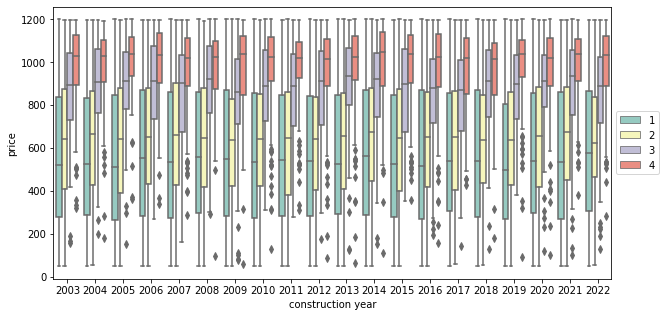

<Figure size 432x288 with 0 Axes>

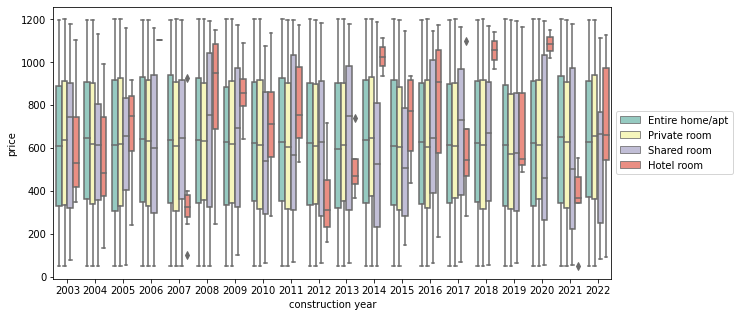

<Figure size 432x288 with 0 Axes>

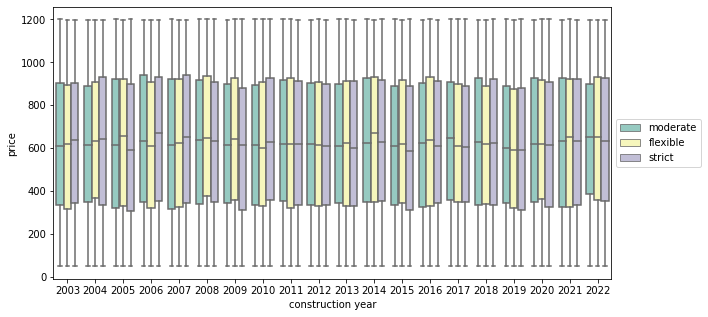

<Figure size 432x288 with 0 Axes>

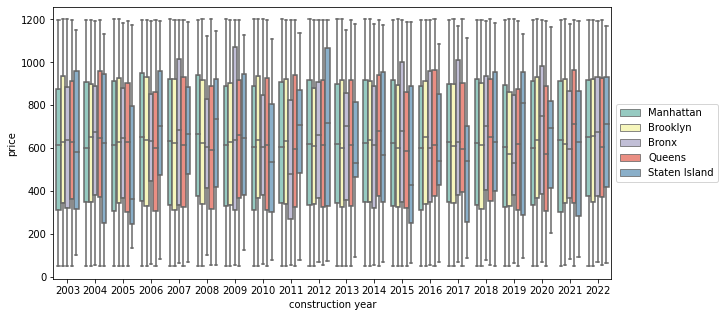

<Figure size 432x288 with 0 Axes>

In [15]:
for hue in ["number rooms", "room type", "cancellation policy", "neighborhood group"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="construction year", y="price", palette="Set3", hue=hue)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()

_Answer:_ No significant correlation noticable (besides the above mentioned).

## Setting the Price

No matter what you have deducted from your analysis, from now on, you will continue only with three features: **The number of rooms, the neighborhood group, and the room type.**

**Enter Toby**: Toby is your long-term friend back from studying at RWTH. While you studied computer science, Toby studied business administration to become a big shot at Wall Street. He currently works in the back office of some swiss credit institute just across the corner from your office. You decide to drop by and get some of his input for your pricing decision. 

Toby proposes to first use comparables pricing to price your apartment. Comparables pricing is an established concept in economics and means that you price your apartment close to similar apartments. 
You will use different techniques to find similar apartments and set a price.

## Baseline

First, you want to set a baseline to compare against. You use the mean absolute error as metric. The baseline should always use the average price of all apartments as a recommended price. Evaluate on a test set of 5%. The same test set should also be used later (you can use the random_state argument in scikit learn's train_test_split, but you need to stay consistent for different questions).

In [16]:
X = df[['number rooms', 'neighborhood group', 'room type']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

predictor = y_train.mean()
score = np.sum(np.abs(y_test - predictor)) / len(y_test)
print(f"Baseline price {predictor:.2f} mean absolute error: {score}")

Baseline price 624.93 mean absolute error: 286.52832633529397


## Decision Tree




Using a decision tree, you try to price your apartment according to similar apartments. 

In the following, we want to know the price ranges for renting AirBnBs. To use decision trees, you need to discretize prices. We use the following price bins:


- [50, 200]
- (200, 400]
- (400, 600]
- (600, 800]
- (800, 1000]
- (1000, 1200]

We add the attribute "Price_Bins" using the discretization mentioned above for each apartment. For example, if an apartment costs 404, it is put into the bin (400, 600].

In [17]:
bins = [50,200,400,600,800,1000,1200]
df['Price_Bins'] = pd.cut(df["price"], bins=bins, include_lowest=True) # Notice: include lowest to get first lower bound ([50,..) inclusive.
df.head()

,id,host id,neighborhood group,neighborhood,lat,long,country,country code,instant bookable,cancellation policy,room type,construction year,price,service fee,minimum nights,number of reviews,review rate number,calculated host listings count,number rooms,Price_Bins
0,1002102,52335172823,Manhattan,Midtown,40.75362,-73.98377,United States,US,0,moderate,Entire home/apt,2007,142,28,7,45,4,2,2,"(49.999, 200.0]"
1,1002403,78829239556,Manhattan,Harlem,40.80902,-73.94190,United States,US,0,flexible,Private room,2005,620,124,3,0,5,1,1,"(600.0, 800.0]"
2,1002755,85098326012,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,0,moderate,Entire home/apt,2005,368,74,7,270,4,1,2,"(200.0, 400.0]"
3,1003689,92037596077,Manhattan,East Harlem,40.79851,-73.94399,United States,US,0,moderate,Entire home/apt,2009,204,41,7,9,3,1,1,"(200.0, 400.0]"
4,1004650,61300605564,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,United States,US,0,moderate,Private room,2015,71,14,7,49,5,1,1,"(49.999, 200.0]"


Consider the extended dataset from the previous task. Use 'number rooms,' 'room type,' and 'neighborhood group' as descriptive features and "Price_Bins" as the target feature. Create a test and training set like before.

In [18]:
X = df[['number rooms', 'neighborhood group', 'room type']]
y = df['Price_Bins']

X_train, X_test, y_train_binned, y_test_binned = train_test_split(X, y, test_size=0.05, random_state=42)

Generate a decision tree in which the minimum number of samples for splitting is ten and use entropy. What is the system's entropy?

Note: For this task, you must use the p_decision_tree library.

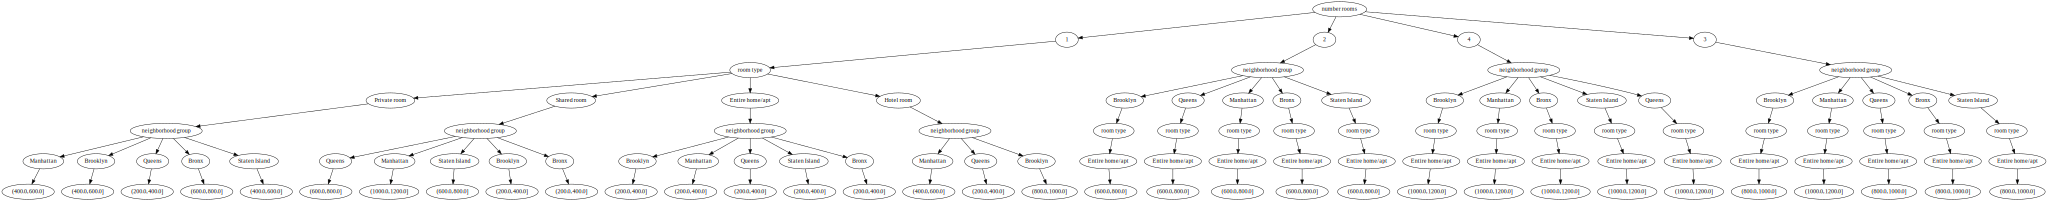

System entropy:  2.5769427958177795


In [19]:
X_data = X_train.astype(str).values.tolist()
X_names = X_train.columns.tolist()
y_data = y_train_binned.astype(str).values.tolist()

decisionTree = DecisionTree(X_data, X_names, y_data, "entropy")
decisionTree.id3(0,10)
dot = decisionTree.print_visualTree( render=False )
display(dot)

print("System entropy: ", format(decisionTree.entropy))

Since it doesn't make sense to set a price range for renting a room, we need to fix a price. For simplicity, we use the means of the bins, i.e., 125, 300, 500, 700, 900, and 1100. For example, if a room were categorized in the bin (200, 400], it would have the price of 300.

What prices are possible given your decision tree for:

- Manhattan, 1-room, Private room
- Staten Island, 1-room, Shared room


_Answer:_ The mean of leaf ranges for the proposed paths are: 500 (Manhatten, 1-room, private) and 700 (Staten Island, 1-room, share).


What is the proposed price of the decision tree for our apartment? Store it in a variable for later usage.

In [20]:
prop_dt_price = 700 # Manhatten, 2-room, apartment

To evaluate how good our decision tree is for determining price categories, we want to measure the error of the predictions on the test set. To do so, the IDS team provided you helper functions below.

In [21]:
def get_name_value_dict(graph):
    id_label_dict = {}
    root = decisionTree.root
    visited = set() # Set to keep track of visited nodes of graph.

    def dfs(visited, graph, node):#function for dfs 
        id_label_dict[node.name] = node.value
        if node not in visited:
            if node.next:
                id_label_dict[node.next.name] = node.next.value
            visited.add(node)
            if node.childs:
                for child in node.childs:
                    if child is not None:
                        dfs(visited, graph, child)
            elif node.next:
                if node.next.childs:
                    for child in node.next.childs:
                        if child is not None:
                            dfs(visited, graph, child)
    dfs(visited, graph, root)
    return id_label_dict

def get_predictor(tree):
  id_label_dict = get_name_value_dict(tree)
  dotplus = pydotplus.graph_from_dot_data(tree.source)
  G = networkx.nx_pydot.from_pydot(dotplus)
  root = [n for n,d in G.in_degree() if d==0][0]
  paths = []
  for node in G:
      if G.out_degree(node)==0: #it's a leaf
          paths.append(networkx.shortest_path(G, root, node))
  new_paths = []
  for path in paths:
      for name, value in id_label_dict.items():
          path = ([p.replace(name, value) for p in path])
      new_paths.append(path)
  predictor = {}
  for path in new_paths.copy():
    target = path[-1]
    classification = tuple(path[:-1])
    predictor[classification] = target
  return predictor

def get_prediction_features(predictor):
    features = set()
    for key in predictor:
        i = 0
        while i <= len(key)-2:
            features.add(key[i])
            i +=2
    return features
            
def get_predicted_bin(instance, features, predictor):
  feature_values = {}
  for feature in features:
      feature_values[feature] = instance[feature]
  possible_paths = predictor.keys()
  i=0
  while i<2*len(feature_values):
    attribute = [path[i] for path in possible_paths][0]
    if attribute in predictor.values():
      break
    feature_value = feature_values[attribute]
    candidates = []
    for el in possible_paths:
      if str(el[i+1]) == str(feature_value):
        candidates.append(el)
    possible_paths = candidates.copy()
    i+=2
  return predictor[possible_paths[0]]



### Dot is your visual decision tree. Adjust the naming if needed
predictor = get_predictor(dot)
features = get_prediction_features(predictor)

To predict the price bin for each instance of your test set, apply the function get_predicted_bin using the variables predictor and features provided above.

In [22]:
preds = [get_predicted_bin(instance, features, predictor) for idx, instance in X_test.iterrows()]

You predicted a price range for AirBnBs in your test set. However, since you cannot enter a price range for renting an apartment, we have to map the range of bins to one value. To do so, we use the mean of bins, as explained before, to predict the price. Given that, compute the mean absolute error between the prediction from the decision tree and the real price provided in the dataset. What is the mean absolute error?

In [23]:
preds_mean = [pd.Interval(*map(float, interval_str[1:-1].split(","))).mid for interval_str in preds] # predictions are strings, so we convert to interval first and then take the mid (mean) of the interval.
print(f"Mean absolute error: {mae(y_test, preds_mean)}")

Mean absolute error: 278.9664126446514


## Clustering

Another way to do comparables pricing is to find similar apartments using clustering. Each calculated cluster represents one or more similar apartments in the dataset. For each cluster, you calculate the mean price as a representative price. To predict the price for new apartments, you assign them to an existing cluster and give the mean price as prediction.

Use the same features you used in the decision tree for the clustering as well (**number rooms, neighborhood group, room type**), and remember that your dataset is still split into a training and test set.

In this task, you will use the k-means algorithm.
*Note: To keep results comparable, please use 100 for random state and n_init when initializing the clustering algorithm. Also, remember to use the same test and training set as in the previous tasks to compare performances.*

### Encoding

K-means tries to calculate the distance between different data points. Since some of the features you want to use are not numeric, apply one-hot encoding to be able to use distance measures. Use the preprocessing module of sklearn to prepare your dataset for clustering.

In [24]:
ohe = OneHotEncoder()
data = ohe.fit_transform(X_train[["room type", "neighborhood group"]])
cols = [name for group in ohe.categories_ for name in group] # flatten
X_train_1h = X_train.drop(columns=["room type", "neighborhood group"])
X_train_1h[cols] = data.toarray()
X_train_1h.head()

,number rooms,Entire home/apt,Hotel room,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
14511,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
32127,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34402,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
51675,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
69390,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Choosing number of clusters

In k-means, the number of wanted clusters is a parameter one can decide on. Since this is information you do not have at this time, you choose to use the data to decide.

You cluster on the training dataset by using `k` number of clusters where `k` is between 4 and 15. Since you are interested in the price, for each clustering, you calculate the **standard deviation of the mean prices for the clusters**. Therefore, for each clustering:
1. Calculate the mean price for each of the resulting clusters.
2. Calculate the standard deviation of the mean prices calculated in 1.

Plot a diagram where on the `x-axis` you will have the *number of clusters used* and on the `y-axis` the *standard deviation of the means*.

In your opinion, which amount of clusters makes more sense? Explain your answer.

In [25]:
model_instances = dict()
for k in range(4,16): # train model_instances
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=100)
    kmeans.fit(X_train_1h.values)
    model_instances[k] = kmeans
    print(f"Finished training KMeans for {k} clusters")

Finished training KMeans for 4 clusters
Finished training KMeans for 5 clusters
Finished training KMeans for 6 clusters
Finished training KMeans for 7 clusters
Finished training KMeans for 8 clusters
Finished training KMeans for 9 clusters
Finished training KMeans for 10 clusters
Finished training KMeans for 11 clusters
Finished training KMeans for 12 clusters
Finished training KMeans for 13 clusters
Finished training KMeans for 14 clusters
Finished training KMeans for 15 clusters


4 clusters, avg. prices: 569.5, 624.2, 529.8, 915.1
5 clusters, avg. prices: 569.5, 624.7, 915.1, 622.4, 527.3
6 clusters, avg. prices: 527.3, 566.8, 915.1, 628.7, 622.4, 622.6
7 clusters, avg. prices: 628.7, 915.1, 622.4, 495.6, 621.9, 537.7, 648.2
8 clusters, avg. prices: 628.7, 711.3, 537.7, 621.9, 622.4, 917.6, 504.6, 493.9
9 clusters, avg. prices: 708.9, 624.5, 507.5, 480.7, 627.6, 621.9, 717.5, 498.5, 945.5
10 clusters, avg. prices: 479.8, 623.4, 923.2, 623.4, 665.3, 627.6, 905.1, 507.5, 624.0, 493.9
11 clusters, avg. prices: 625.1, 495.3, 623.4, 507.5, 923.2, 621.9, 480.7, 629.7, 665.3, 905.1, 628.2
12 clusters, avg. prices: 623.4, 495.3, 507.5, 621.9, 905.1, 480.7, 629.7, 665.3, 628.2, 883.7, 948.2, 625.1
13 clusters, avg. prices: 621.9, 468.9, 905.1, 665.3, 623.4, 630.0, 499.9, 493.9, 948.2, 624.0, 883.7, 614.6, 626.4
14 clusters, avg. prices: 471.7, 623.4, 905.1, 665.3, 621.9, 630.0, 499.9, 493.9, 628.2, 889.0, 948.2, 614.6, 626.4, 576.3
15 clusters, avg. prices: 471.7, 623.4

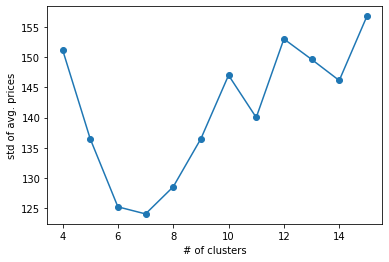

In [26]:
stds = []
for k, model in model_instances.items(): # evaluate model_instances
    cluster_ids = model.predict(X_train_1h.values)
    
    avg_prices = []
    for i in range(k):
        prices_in_cluster = y_train[cluster_ids == i]
        avg_prices.append( np.mean(prices_in_cluster) )

    std_avg_prices = np.std(avg_prices)
    print(f"{k} clusters, avg. prices: {', '.join([f'{c:.1f}' for c in avg_prices])}")
    stds.append(std_avg_prices)

plt.plot(range(4,16), stds, '-o')
plt.xlabel("# of clusters")
plt.ylabel("std of avg. prices");

_Answer:_ Ideally we would want low inner-cluster variance and large cluster-cluster variance, i.e. large distances between the centroids. From this argument we would tend more towards larger cluster sizes of 12 or 15.

**Note:** No matter the conclusion made in the previous task, from now on, you use the clustering model with **9 clusters** for predicting the price for your apartment and evaluating the clustering technique.

### Pricing your apartment

To predict the price for your apartment, calculate in which cluster your apartment would be and use the mean value of the cluster as a possible price.

In [26]:
# cluster for 9 clusters
model = model_instances[9]

our_apt = pd.DataFrame([[2, 1, 0, 0, 0, 0, 0, 1, 0, 0]], columns=X_train_1h.columns)

cluster_id = model.predict(our_apt.values)
cluster_ids = model.predict(X_train_1h.values)

prop_cluster_price = np.mean(y_train[cluster_ids == cluster_id])
print(f"Our apartment lies in cluster {cluster_id} with average price {prop_cluster_price:.2f}")

Our apartment lies in cluster [6] with average price 717.49


### Evaluating clustering

You want to evaluate how well your clustering worked. In your case, two things can be evaluated:

1.   Whether the clustering technique can group similar apartments together
2.   Whether other people determine the price of their apartment as you did, meaning whether similar apartments get a similar price

You are going to evaluate the clustering technique visually. The following fancy code has been provided to reduce your input to two dimensions.

In [27]:
import umap.umap_ as umap

x_train = X_train

#Preprocessing numerical
full_data = x_train # use the train dataset here
numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = sklearn.preprocessing.PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components,
                                                fit1._initial_alpha, fit1._a, fit1._b,
                                                fit1.repulsion_strength, fit1.negative_sample_rate,
                                                200, 'random', np.random, fit1.metric,
                                                fit1._metric_kwds, False, {}, False)

# Extracting the resulting dimensions
dimension1 = embedding[0].T[0]
dimension2 = embedding[0].T[1]

C:\Users\riyat\anaconda3\envs\IDS22\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


Create a scatter plot from the two dimensions and use the cluster labels for coloring the data points. Use the train set for the visualization. Discuss the result.

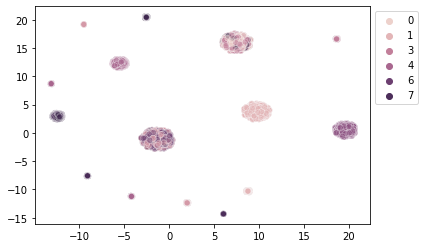

In [28]:
ax = sns.scatterplot(x=dimension1, y=dimension2, hue=cluster_ids, alpha=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

_Answer:_ We can see relatively good separation of the main clusters. Best isolated is cluster 0, which seems perfectly isolated from the rest. The other clusters contain some instances of other clusters too. The smaller clusters can probably be considered as outliers in this projection (although we cannot be sure without better understanding of the applied transformation).


We next evaluate whether similar apartments (considering the attributes we chose) get similar prices. To do this, we use our test set. Assign each apartment of the test set to the nearest centroid. Predict the price of the apartments in the test set by taking the mean price of the cluster they was assigned to. Calculate the mean absolute error between the predicted and real prices.

In [29]:
ohe = OneHotEncoder()
data = ohe.fit_transform(X_test[["room type", "neighborhood group"]])
cols = [str(name) for group in ohe.categories_ for name in group] # flatten
X_test_1h = X_test.drop(columns=["room type", "neighborhood group"])
X_test_1h[cols] = data.toarray()

# predict test data
preds = np.zeros(len(y_test))
cluster_ids = model.predict(X_test_1h.values)
for cluster_id in cluster_ids:
    centroid = np.mean(y_test[cluster_ids == cluster_id])
    preds[cluster_ids == cluster_id] = centroid

print(f"Mean absolute error: {mae(y_test, preds)}")

Mean absolute error: 262.5599450053347


## Final comments on the price prediction

Please compare the three approaches used for determining the price. Do they provide a good way of determining the price?

_Answer:_ Clustering yields the best result, although the absolute error for this approach is still pretty large. This leaves the question open if there might be a better method to predict the price.

## Investigating Price Elasticity

You show your results to Toby, excited about the price suggestions you got from the decision tree and clustering. You decide to take the higher price, which naturally means more income.

However, he points you to one central flaw in your thinking: The number of bookings is not independent of the price. Therefore, you can not just take any price and assume that this will lead to more income than a lower price, as the demand (utilization) for your apartment might decrease. This is called **price elasticity**.

You want to verify what Toby has been telling you. You extracted the utilization column of your dataset by grabbing the available data from AirBnB's calendar (smart!). The utilization values are contained in dataset **AirBnB_utilization.csv**. **Show several graphs investigating price elasticity.** For example, you might plot the utilization in relation to the price and color according to different variable values. 
After you have verified Toby's statements, you want to learn price elasticity from the dataset (the utilization of an apartment given the price, the number of rooms, the room type, and the neighborhood group, i.e., the same features as before). With the learned price elasticity, you want to evaluate which of the proposed prices (decision tree or clustering) is the better choice. 

<AxesSubplot: xlabel='price', ylabel='utilization'>

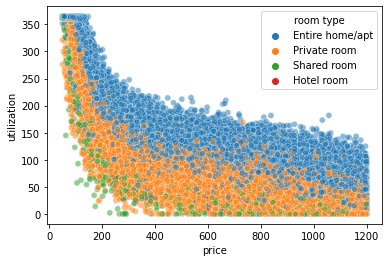

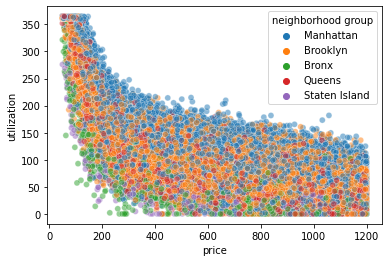

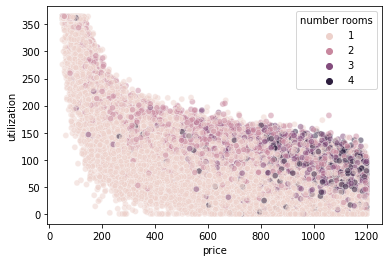

In [30]:
df = pd.read_csv('AirBnB_utilization.csv')

sns.scatterplot(data=df, x='price', y='utilization', hue='room type', alpha=0.5)
plt.figure()
sns.scatterplot(data=df, x='price', y='utilization', hue='neighborhood group', alpha=0.5)
plt.figure()
sns.scatterplot(data=df, x='price', y='utilization', hue='number rooms', alpha=0.5)

You will investigate the relationship between price and utilization in this subtask. First, you will train different models and choose the one that best predicts utilization for an apartment. Second, you will evaluate which of the proposed prices of decision tree and clustering prices were better, assuming that your model provides the correct utilization. Third, you will conclude your investigation and provide a pricing decision.

### Learning price elasticity
You want to use different supervised learning techniques to learn price elasticity. You decide on linear regression, SVM, and multilayer perceptrons. However, you have to preprocess the data. Use the features of the neighborhood group, the room type, the number of rooms, and the price to predict the utilization. Split into training and testing data (test size 5%).

#### Prepare the data set by splitting, one-hot encoding, and normalizing.

In [31]:
ohe = OneHotEncoder()
data = ohe.fit_transform(df[["room type", "neighborhood group"]])
cols = [name for group in ohe.categories_ for name in group] # flatten
df1h = df.drop(columns=["room type", "neighborhood group"])
df1h[cols] = data.toarray()

utilization_scaler = MinMaxScaler().fit(df1h[['utilization']])
df1h[['utilization']] = utilization_scaler.transform(df1h[['utilization']])
price_scaler = MinMaxScaler().fit(df1h[['price']]) # transform price, store scaler for later rescaling
df1h[['price']] = price_scaler.transform(df1h[['price']])

X = df1h.drop(columns=['id', 'utilization'])
y = df1h[['utilization']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
## inserted
our_apt = pd.DataFrame([[2, 1, 0, 0, 0, 0, 0, 1, 0, 0]], columns=X_train.columns[:1].tolist() + X_train.columns[2:].tolist())
X_train.head()

,number rooms,price,Entire home/apt,Hotel room,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
14511,1,0.146087,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
32127,2,0.625217,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34402,1,0.680870,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
51675,1,0.351304,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
69390,2,0.862609,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


For each technique, use 5-cross-fold validation for hyperparameter optimization and assess the performance on the test set. 

#### Regression

Learn a linear regression to predict the utilization of an AirBnB.

In [32]:
grid = GridSearchCV(LinearRegression(), 
                    param_grid={'fit_intercept': [True,False]}, 
                    cv=5, 
                    verbose=3, 
                    scoring='neg_mean_absolute_error') 

grid.fit(X_train.values, y_train.values.flatten());
print(f'Best parameters for the model: {grid.best_params_}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...............fit_intercept=True;, score=-0.095 total time=   0.0s
[CV 2/5] END ...............fit_intercept=True;, score=-0.096 total time=   0.0s
[CV 3/5] END ...............fit_intercept=True;, score=-0.096 total time=   0.0s
[CV 4/5] END ...............fit_intercept=True;, score=-0.098 total time=   0.0s
[CV 5/5] END ...............fit_intercept=True;, score=-0.097 total time=   0.0s
[CV 1/5] END ..............fit_intercept=False;, score=-0.095 total time=   0.0s
[CV 2/5] END ..............fit_intercept=False;, score=-0.096 total time=   0.0s
[CV 3/5] END ..............fit_intercept=False;, score=-0.096 total time=   0.0s
[CV 4/5] END ..............fit_intercept=False;, score=-0.098 total time=   0.0s
[CV 5/5] END ..............fit_intercept=False;, score=-0.097 total time=   0.0s
Best parameters for the model: {'fit_intercept': False}


What is the mean absolute error achieved on the test data?

In [33]:
# Train model again with optimal hyperparameters
linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train.values, y_train.values.flatten())
mae_val = mae(y_test, linreg.predict(X_test.values))
print(f"Mean absolute error on test set: {mae_val}")

Mean absolute error on test set: 0.0970272275456279


Show (draw!) the price elasticity for your apartment. 

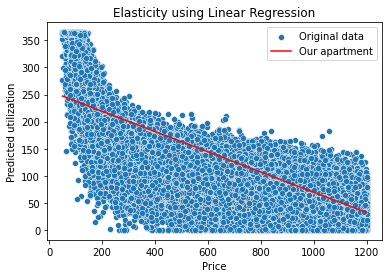

In [34]:
utilizations = []
prices = np.linspace(0,1,50)
for price in prices:
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    utilizations.append(linreg.predict(our_apt_.values)[0])

sns.scatterplot(data=df, x='price', y='utilization')    
plt.plot(price_scaler.inverse_transform([prices])[0], utilization_scaler.inverse_transform([utilizations])[0], c='red')
plt.title("Elasticity using Linear Regression")
plt.xlabel('Price')
plt.ylabel('Predicted utilization');
plt.legend(['Original data', 'Our apartment']);

# We see the utilization of our apartment as a function of price,
# where each utilization value is predicted from number of rooms, 
# room type, neighborhood group and price. The latter we vary from 0 to max
# and thereby obtain a prediction of utilization of our apartment for each
# possible price value. We expect this curve to ideally have a similar progression
# as the original data (which we plot in the background)

#### Linear SVR

Train and evaluate a Linear SVR (Support Vector Regression) model.

In [35]:
param_grid = {'C':[0.1,0.2, 0.5, 1],
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv = 5, verbose = 3, scoring = 'neg_mean_absolute_error') 
grid.fit(X_train.values, y_train.values.flatten())

print(f'Best parameters for the model: {grid.best_params_}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.088 total time=   0.3s
[CV 2/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.090 total time=   0.3s
[CV 3/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.089 total time=   0.3s
[CV 4/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.091 total time=   0.2s
[CV 5/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.090 total time=   0.3s
[CV 1/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.095 total time=   0.0s
[CV 2/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.096 total time=   0.1s
[CV 3/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.096 total time=   0.1s
[CV 4/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.098 total time=   0.0s
[CV 5/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.097 total time=   0.0s
[CV 1/5] END ..C=0.2, loss=epsilon_insensitive;, score=-0.088 total time=   0.5s
[CV 2/5] END ..C=0.

What is the mean absolute error achieved on the test data?

In [36]:
# Train model again with optimal hyperparameters
linsvr = LinearSVR(C=1, loss='epsilon_insensitive',max_iter=10000)
linsvr.fit(X_train.values, y_train.values.flatten())
mae_val = mae(y_test, linreg.predict(X_test.values))
print(f"Mean absolute error on test set: {mae_val}")

Mean absolute error on test set: 0.0970272275456279


Show (draw!) the price elasticity for your apartment. 

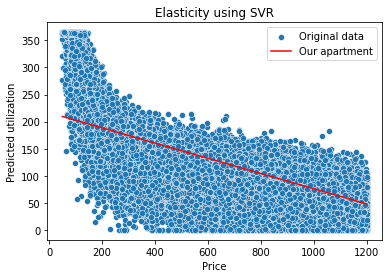

In [37]:
utilizations = []
prices = np.linspace(0,1,50)
for price in prices:
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    utilizations.append(linsvr.predict(our_apt_.values)[0])

sns.scatterplot(data=df, x='price', y='utilization')    
plt.plot(price_scaler.inverse_transform([prices])[0], utilization_scaler.inverse_transform([utilizations])[0], c='red')
plt.title("Elasticity using SVR")
plt.xlabel('Price')
plt.ylabel('Predicted utilization');
plt.legend(['Original data', 'Our apartment'])

#### Learning Non-Linear Relationships

You realize that learning linear relationships only provides limited performance. You want to learn non-linear relationships. First, you will learn non-linear relationships using linear regression and kernels. Second, you will use non-linear kernels in the Support Vector Regression. Third, you will use neural networks.

#### Kernels in Regression

Use a transformation of the price and a regression to incorporate non-linear relationships, as learned in the lecture. You can try different kernel functions, but at least you should use one quadratic kernel.

In [38]:
X_train2 = X_train.copy()
X_train2['price2'] = X_train['price']**2 # Add variable price^2

param_grid = {'C':[0.1,0.2, 0.5, 1],
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv = 5, verbose = 3, scoring = 'neg_mean_absolute_error') 
grid.fit(X_train2.values, y_train.values.flatten())
print(f'Best parameters for the model: {grid.best_params_}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.076 total time=   0.3s
[CV 2/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.077 total time=   0.3s
[CV 3/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.077 total time=   0.3s
[CV 4/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.078 total time=   0.3s
[CV 5/5] END ..C=0.1, loss=epsilon_insensitive;, score=-0.077 total time=   0.3s
[CV 1/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.078 total time=   0.0s
[CV 2/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.078 total time=   0.1s
[CV 3/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.078 total time=   0.1s
[CV 4/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.079 total time=   0.1s
[CV 5/5] END C=0.1, loss=squared_epsilon_insensitive;, score=-0.078 total time=   0.0s
[CV 1/5] END ..C=0.2, loss=epsilon_insensitive;, score=-0.076 total time=   0.5s
[CV 2/5] END ..C=0.

What is the mean absolute error achieved on the test data?

In [39]:
lsvr2 = LinearSVR(max_iter=10000, C=1, loss='epsilon_insensitive')
lsvr2.fit(X_train2.values, y_train.values.flatten())

X_test2 = X_test.copy()
X_test2['price2'] = X_test['price']**2

score = mae(y_test, lsvr2.predict(X_test2.values))
print(f'Mean absolute error on test set: {score}')

Mean absolute error on test set: 0.0789245762871981


Show (draw!) the price elasticity for your apartment. 

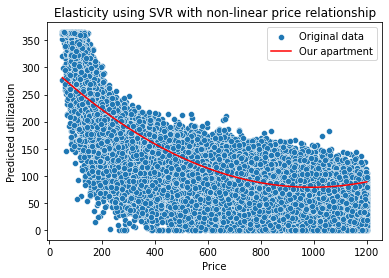

In [40]:
utilizations = []
prices = np.linspace(0,1,50)
for price in prices:
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    our_apt_['price2'] = price**2
    utilizations.append(lsvr2.predict(our_apt_.values)[0])

sns.scatterplot(data=df, x='price', y='utilization')
plt.plot(price_scaler.inverse_transform([prices])[0], utilization_scaler.inverse_transform([utilizations])[0], c='red')
plt.title("Elasticity using SVR with non-linear price relationship")
plt.xlabel('Price')
plt.ylabel('Predicted utilization');
plt.legend(['Original data', 'Our apartment'])

#### Kernels in SVR

Train and evaluate an SVR (Support Vector Regression) model with different, non-linear kernels. You can limit the size of your training set to 25000 samples to make the problem feasible in computation time.

In [41]:
N = 25_000
X_train3, y_train3 = X_train.iloc[:N], y_train.iloc[:N]
# Additional to a reduced training set we use no cross-validation. We are only interested 
# in seeing the approximate behaviour of different kernels without tuning any hyperparameters.

ksvrs = {
    'poly': SVR(kernel='poly', degree=3), # let's try out a cubic polynomial
    'rbf': SVR(kernel='rbf')
}

for ksvr in ksvrs.values(): # train each on training set
    ksvr.fit(X_train.values, y_train.values.flatten())

What is the mean absolute error achieved on the test data?

In [42]:
for kernel, ksvr in ksvrs.items():
    score = mae(y_test, ksvr.predict(X_test.values))
    print(f"Kernel {kernel}, mean absolute error on test set: {score}")

Kernel poly, mean absolute error on test set: 0.06739992072497997
Kernel rbf, mean absolute error on test set: 0.06457635559614192


Show (draw!) the price elasticity for your apartment. 

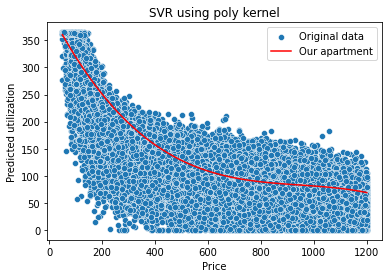

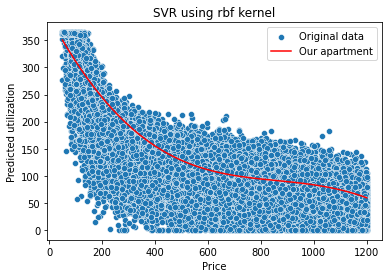

<Figure size 432x288 with 0 Axes>

In [43]:
prices = np.linspace(0,1,50)

for kernel, ksvr in ksvrs.items():
    utilizations = []
    for price in prices:
        our_apt_ = our_apt.copy()
        our_apt_.insert(1, 'price', price)

        pred = ksvr.predict(our_apt_.values)
        utilizations.append(pred[0])
    
    sns.scatterplot(data=df, x='price', y='utilization')
    plt.plot(price_scaler.inverse_transform([prices])[0], utilization_scaler.inverse_transform([utilizations])[0], c='red')
    plt.xlabel('Price')
    plt.ylabel('Predicted utilization')
    plt.title(f'SVR using {kernel} kernel')
    plt.legend(['Original data', 'Our apartment'])
    plt.figure()

What is your conclusion on using kernels?

_Answer:_ 
The `rbf` kernel seems to converge the fasted and gives almost the same result as with `poly`. We also tested the `sigmoid` kernel but got very bad performance, so we excluded it from here. We decided to not tune any hyperparameters as this takes very long on my computer and the task only states to try out the kernels but not to optimize those.

#### Neural Network

Learn a neural network (multilayer perceptron) to predict the utilization of an AirBnB.

In [44]:
param_grid = {'hidden_layer_sizes':[(10,), (50,), (100,)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.005],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'max_iter': [200, 1000, 10000]}
grid = GridSearchCV(MLPRegressor(random_state=42), param_grid, cv = 5, verbose = 3, scoring = 'neg_mean_absolute_error') 
grid.fit(X_train.values, y_train.values.flatten())

print(f'Best parameters for the model: {grid.best_params_}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.096 total time=   0.8s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.096 total time=   0.8s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.097 total time=   0.8s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.098 total time=   0.8s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.098 total time=   0.8s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.096 total time= 

[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.151 total time=   0.5s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.155 total time=   0.5s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.155 total time=   0.6s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.096 total time=   0.7s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.096 total time=   0.6s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.096 total time=   0.7s
[CV 4/5] END activation=identit

[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.097 total time=   1.5s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.097 total time=   1.1s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.097 total time=   1.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.097 total time=   0.9s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.098 total time=   1.0s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.098 total time=   1.1s
[CV 1/5] END activation=identity, alpha=0.0001,

[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.097 total time=   1.6s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.097 total time=   1.4s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.098 total time=   1.3s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.098 total time=   1.4s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.095 total time=   7.2s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.096 total time=   5.8s
[CV 3/5] END activation=identity, alpha=0.0001, hidd

[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.098 total time=   1.2s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.096 total time=   1.4s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.102 total time=   1.2s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.105 total time=   1.1s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.103 total time=   1.1s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.104 total time=   1.0s
[CV 5/5] END activation=identity, alph

[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.095 total time=   6.9s
[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.096 total time=   7.0s
[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.096 total time=   6.8s
[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.6s
[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.097 total time=   6.4s
[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.095 total time=   1.1s
[CV 2/5] END activation=identity, alpha

[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.151 total time=   0.6s
[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.155 total time=   0.7s
[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.155 total time=   0.5s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.096 total time=   0.8s
[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.096 total time=   0.9s
[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.096 total time=   0.9s
[CV 4/5] END activation=identity, alpha=0.0

[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.097 total time=   1.1s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.097 total time=   1.0s
[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.097 total time=   1.1s
[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.096 total time=   1.1s
[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.098 total time=   1.0s
[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.098 total time=   1.0s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer

[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.097 total time=   2.0s
[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.096 total time=   1.3s
[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.098 total time=   1.3s
[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.098 total time=   1.8s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.095 total time=  10.3s
[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.096 total time=   6.1s
[CV 3/5] END activation=identity, alpha=0.00

[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.097 total time=   1.2s
[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.096 total time=   1.6s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.095 total time=   1.6s
[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.096 total time=   1.2s
[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.096 total time=   1.3s
[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.098 total time=   1.5s
[CV 5/5] END activation=identity, alpha=0.005,

[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.095 total time=   7.1s
[CV 2/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.096 total time=   6.8s
[CV 3/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.096 total time=   7.2s
[CV 4/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.098 total time=   6.2s
[CV 5/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.097 total time=   6.3s
[CV 1/5] END activation=identity, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.095 total time=   1.1s
[CV 2/5] END activation=identity, alpha=0.005, hidd

[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.161 total time=   0.5s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.162 total time=   0.6s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.162 total time=   0.6s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.059 total time=   2.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.060 total time=   2.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.060 total time=   2.0s
[CV 4/5] END activation=logistic, alpha=0.0

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.093 total time=   5.9s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.059 total time=   2.0s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.060 total time=   2.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.060 total time=   2.2s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.060 total time=   2.3s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.059 total time=   2.0s
[CV 1/5] END activation=logistic, alpha=0

[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.060 total time=   4.4s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.061 total time=   4.4s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.062 total time=   4.3s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.060 total time=   4.5s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.158 total time=   1.3s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.162 total time=   1.4s
[CV 3/5] END activation=logistic, 

[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.061 total time=   7.3s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.060 total time=   7.3s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.094 total time=  10.6s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.094 total time=  11.0s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.094 total time=   9.9s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.094 total time=   8.9s
[CV 5/5] END activation=logistic, alpha=0.0001

[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.060 total time=   7.1s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.092 total time=  19.4s
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.094 total time=  19.1s
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.093 total time=  24.5s
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.095 total time=  20.9s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.094 total time=  19.9s
[CV 1/5] END activation=logistic, alpha=0.0001,

[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.094 total time=   3.1s
[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.093 total time=   3.1s
[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.095 total time=   3.0s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.093 total time=   3.1s
[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.063 total time=   2.0s
[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.063 total time=   2.1s
[CV 3/5] END activation=logistic, alpha=0.005, hid

[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.094 total time=   5.6s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.093 total time=   5.7s
[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.063 total time=   1.9s
[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.063 total time=   1.9s
[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.063 total time=   2.0s
[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.063 total time=   1.9s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_

[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.062 total time=   5.5s
[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.063 total time=   5.7s
[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.063 total time=   6.8s
[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.063 total time=   7.4s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.063 total time=   5.9s
[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.158 total time=   1.5s
[CV 2/5] END activation=logistic, alpha=0.005,

[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.063 total time=   9.7s
[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.063 total time=   9.8s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.063 total time=   9.2s
[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.094 total time=  17.4s
[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.094 total time=  16.9s
[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.094 total time=  15.5s
[CV 4/5] END activation=logistic, alpha=0.005, hidde

[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.095 total time=   4.9s
[CV 1/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.145 total time=   4.2s
[CV 2/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.149 total time=   4.6s
[CV 3/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.146 total time=   4.5s
[CV 4/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.147 total time=   3.8s
[CV 5/5] END activation=logistic, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.147 total time=   4.4s
[CV 1/5] END activation=logistic, 

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.098 total time=   0.9s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.099 total time=   0.9s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.100 total time=   1.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.099 total time=   1.0s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.055 total time=   1.8s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.055 total time=   1.9s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), lear

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.099 total time=   3.4s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.055 total time=   1.8s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.055 total time=   1.9s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.055 total time=   1.8s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.055 total time=   1.9s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.055 total time=   2.0s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10,), learnin

[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.055 total time=   3.8s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.056 total time=   3.6s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.109 total time=   1.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.111 total time=   1.1s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.108 total time=   1.0s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=200, solver=sgd;, score=-0.111 total time=   1.0s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,)

[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.9s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.4s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.100 total time=   6.8s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.7s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.056 total time=   3.6s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.056 total time=   3.7s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,)

[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.106 total time=   1.6s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.055 total time=   4.8s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.055 total time=   4.9s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.056 total time=   4.6s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.055 total time=   4.8s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.056 total time=   4.5s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_la

[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.056 total time=   1.8s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.056 total time=   1.7s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.056 total time=   1.7s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.098 total time=   0.8s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.098 total time=   1.0s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=1000, solver=sgd;, score=-0.099 total time=   1.0s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate

[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.097 total time=   3.4s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.097 total time=   3.6s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.099 total time=   3.3s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.099 total time=   3.6s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.099 total time=   3.2s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=adam;, score=-0.056 total time=   1.8s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=adap

[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.099 total time=   1.3s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.057 total time=   3.2s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.057 total time=   3.2s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.057 total time=   3.2s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.062 total time=   2.7s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.058 total time=   2.9s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), le

[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.062 total time=   2.6s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.058 total time=   3.3s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.097 total time=   6.7s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.7s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.098 total time=   6.6s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=10000, solver=sgd;, score=-0.100 total time=   6.7s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50,), learnin

[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.106 total time=   1.6s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.105 total time=   1.4s
[CV 4/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.106 total time=   1.5s
[CV 5/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.106 total time=   1.5s
[CV 1/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.056 total time=   4.8s
[CV 2/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=adam;, score=-0.057 total time=   4.6s
[CV 3/5] END activation=tanh, alpha=0.005, hidden_layer_sizes=

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.091 total time=   1.7s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.054 total time=   1.6s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.055 total time=   1.5s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.054 total time=   1.9s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.055 total time=   1.6s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.055 total time=   1.7s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learnin

[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.054 total time=   1.9s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   1.5s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   1.7s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.089 total time=   4.4s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.090 total time=   4.3s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,), learning_rate=adaptive, max_iter=200, solver=sgd;, score=-0.090 total time=   4.2s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,

[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.092 total time=   2.0s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.092 total time=   2.0s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.093 total time=   1.8s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.092 total time=   2.3s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.053 total time=   1.9s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=adam;, score=-0.054 total time=   1.9s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,)

[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.091 total time=   8.1s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.053 total time=   2.2s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.054 total time=   2.2s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.054 total time=   1.9s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.054 total time=   2.1s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.054 total time=   2.2s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), l

[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.054 total time=   2.7s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.054 total time=   2.7s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.053 total time=   2.7s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.107 total time=   2.0s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.110 total time=   1.9s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.108 total time=   2.1s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_s

[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.090 total time=   1.6s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.090 total time=   1.6s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.091 total time=   1.6s
[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.092 total time=   1.7s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=sgd;, score=-0.091 total time=   1.6s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=constant, max_iter=200, solver=adam;, score=-0.055 total time=   1.5s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=cons

[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=sgd;, score=-0.193 total time=   0.5s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   1.8s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.056 total time=   1.4s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   1.5s
[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   1.5s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(10,), learning_rate=invscaling, max_iter=10000, solver=adam;, score=-0.055 total time=   2.1s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_siz

[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.054 total time=   1.9s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, solver=adam;, score=-0.053 total time=   1.8s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.091 total time=   2.0s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.092 total time=   2.1s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.092 total time=   1.9s
[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=10000, solver=sgd;, score=-0.093 total time=   1.9s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learnin

[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.091 total time=   8.1s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.091 total time=   8.0s
[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.093 total time=   7.9s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=sgd;, score=-0.091 total time=   7.8s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.053 total time=   2.1s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, solver=adam;, score=-0.054 total time=   2.0s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(50,), learning_ra

[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.053 total time=   2.6s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.054 total time=   2.6s
[CV 3/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.054 total time=   2.4s
[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.054 total time=   2.9s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=200, solver=adam;, score=-0.053 total time=   2.5s
[CV 1/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, solver=sgd;, score=-0.107 total time=   1.8s
[CV 2/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(1

[CV 4/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.054 total time=   2.8s
[CV 5/5] END activation=relu, alpha=0.005, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=10000, solver=adam;, score=-0.053 total time=   2.5s
Best parameters for the model: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}


What is the mean absolute error achieved on the test data?

In [45]:
mlp = MLPRegressor(activation='relu', alpha=0.005, hidden_layer_sizes=(50,), learning_rate='constant', max_iter=200, solver='adam', random_state=42)
mlp.fit(X_train.values, y_train.values.flatten())
score = mae(y_test, mlp.predict(X_test.values))
print(f'Mean absolute error on test set: {score}')

Mean absolute error on test set: 0.05465098122185229


Show (draw!) the price elasticity for your apartment. 

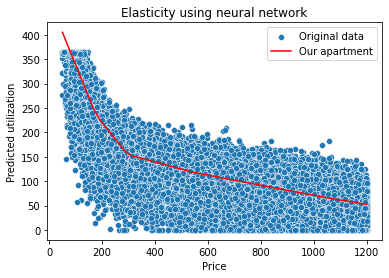

In [46]:
utilizations = []
prices = np.linspace(0,1,50)
for price in prices:
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    utilizations.append(mlp.predict(our_apt_.values)[0])

sns.scatterplot(data=df, x='price', y='utilization')
plt.plot(price_scaler.inverse_transform([prices])[0], utilization_scaler.inverse_transform([utilizations])[0], c='red')
plt.xlabel('Price')
plt.ylabel('Predicted utilization');
plt.title(f'Elasticity using neural network')
plt.legend(['Original data', 'Our apartment']);

### Profit discrepencies when incorporating price elasticity

Use the model that best captures price elasticity on the testing set. You can assume that this model accurately captures price elasticity, i.e., is the ground truth. What is the better of the two proposed prices? Is the better price the optimal price?

In [47]:
# Your answer goes here
utilizations = []

for price in price_scaler.transform(pd.DataFrame([[prop_dt_price], [prop_cluster_price]], columns=['price'])):
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    utilizations.append(mlp.predict(our_apt_.values)[0])

uts = utilization_scaler.inverse_transform([utilizations])[0]
dt_utilization_5yrs, cluster_utilization_5yrs = uts * 5

print(f"Total income over 5 years for proposed price (decision tree) of {prop_dt_price:.2f} $/night with utilization of {uts[0]:.1f} days/year: {prop_dt_price * dt_utilization_5yrs:.2f}")
print(f"Total income over 5 years for proposed price (clustering) of {prop_cluster_price:.2f} $/night with utilization of {uts[1]:.1f} days/year: {prop_cluster_price * cluster_utilization_5yrs:.2f}")

Total income over 5 years for proposed price (decision tree) of 700.00 $/night with utilization of 101.8 days/year: 356364.16
Total income over 5 years for proposed price (clustering) of 717.49 $/night with utilization of 100.0 days/year: 358832.87


Maximum income of $367334.90 for a price of $851.52.


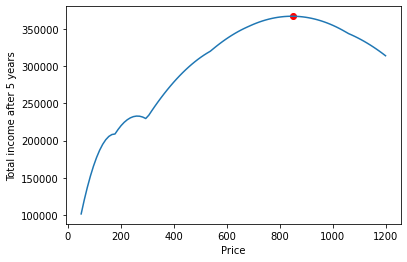

In [48]:
# Optimal price: Want to maximize overall income over 5 years.
incomes = []
prices = np.linspace(0,1,100)
for price in prices:
    our_apt_ = our_apt.copy()
    our_apt_.insert(1, 'price', price)
    
    pred = mlp.predict(our_apt_.values)[0]
    
    util = utilization_scaler.inverse_transform([[pred]])[0]
    price = price_scaler.inverse_transform([[price]])[0]
    incomes.append(util * 5 * price)

prices = price_scaler.inverse_transform([prices])[0]

max_idx = np.argmax(incomes)

plt.plot(prices, incomes)
plt.scatter([prices[max_idx]], incomes[max_idx], c='red')
plt.xlabel('Price')
plt.ylabel('Total income after 5 years');

print(f"Maximum income of ${incomes[max_idx][0]:.2f} for a price of ${prices[max_idx]:.2f}.")

_Answer:_ The higher price seems to be the better choice as it yields a larger overall income over 5 years. However, the optimal price is about $850 per month.

# Conclusion

Summarize your findings and discuss limitations.

_Answer:_ 

To examine data and the relationships of the features to each other, plots should be used to represent the relationships. Plots such as boxplots and histograms provide important information within a feature. 
To examine the relationship between multiple features, multivariate analyses should be performed. 
By doing this, we have seen that not all features in the data set are important for pricing. The most crucial feature was the number of rooms, which is related to the type of room.

For pricing, we first used a naive estimator as the mean of all training labels and subsequently used more sophisticated methods such as decision tree method and clustering, which yielded better (although not *much* better results). 
Since many classification methods cannot work with categorical features, they must first be converted into numerical ones. In this task, we accomplished this by using One Hot Encoding. However, we did not One-Hot-encoded the "number of rooms" feature, since this implies an ordinal order, and since changing the order of the features with the One-Hot-encoded feature of "number of rooms" resulted in larger errors, we concluded that the ordinal order should be maintained. Furthermore, if we would one-hot-encode the number of rooms all data would be one-hot encoded, for which usage of KMeans should be avoided and instead KModes should be used, as the Euclidean distance metric does not make sense for one-hot-encodings. For mixed data there is also the KPrototype algorithms, which would probably be the better choice for our type of data. Also, we noticed with KMeans that interchanging the order of the one-hot encoded data "blocks" yields slightly different results in the clustering. We think changing the order of columns should have no effect on the outcome, so we are not sure why this is happening. We saw this only happening when we have one-hot encoded data and not for purely numerical data, thus this might be a problem with the Euclidean distance metric of KMeans. 

Both methods (clustering and decision tree) provided good initial estimates of the price for our apartment, since it takes into account the different characteristics. But the average absolute error was relatively high at 260 to 278, with clustering providing better results. 
One reason could be that the selected features were not ideally chosen for estimating the price, as they might not be that important. 

Afterwards we examined another feature, the utilization. Linear regression and linear support vector machines were used first, through which the utilization should be predicted based on the price and the previous features. With a previous plot depicting the relationship between price and usage, one can directly see the non-linear relationship of the two features. Therefore, the linear regression and linear SVMs obtained poor results and it is necessary to choose a model that can describe the non-linear relationship. 
Therefore, non-linear kernels were then used for the SVM, which gave much better results.
In the end, we used neural networks for the predictions of utilization, which gave the best overall results, i.e. the smallest error. 
Neural networks provide a good way to predict more accurate utilization compared to the other models. They are more adaptable and training the model is also faster. 
The prediction of the price can also take advantage of the models that were used to predict utilization. Since these gave good results, it could possibly be possible to predict the price more accurately. However, this would need to be investigated in more detail.